In [1]:
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision import datasets
from collections import Counter

from classic_vit import ViT
from her2_dataset import HER2Dataset
from patch_embedding import PatchEmbedding

transform = ToTensor()

torch.manual_seed(0)

IMAGE_WIDTH = 299
IMAGE_HEIGHT = 299
IMAGE_CHANNELS = 3
N_PATCHES = 13

MAX_CHECKPOINTS = 3

assert IMAGE_WIDTH%N_PATCHES==0

PATCH_WIDTH = IMAGE_WIDTH//N_PATCHES
PATCH_HEIGHT = IMAGE_HEIGHT//N_PATCHES


DATASET_PATH='../datasets/HER2_gastric_5classes'
# 20% of data goes to test
TEST_SPLIT = 0.2
BATCH_SIZE = 16

N_EPOCHS = 100
LR = 0.00001


In [2]:

dataset = HER2Dataset(DATASET_PATH, transform=ToTensor())
train_dataset, test_dataset = dataset.genSplits(TEST_SPLIT)
train_loader, test_loader = dataset.getDataLoaders(BATCH_SIZE)

print(f"Dataset split:\nTrain: {len(train_dataset)}\nTest: {len(test_dataset)}")



Dataset split:
Train: 1627
Test: 406


Text(0.5, 1.0, 'Test Split')

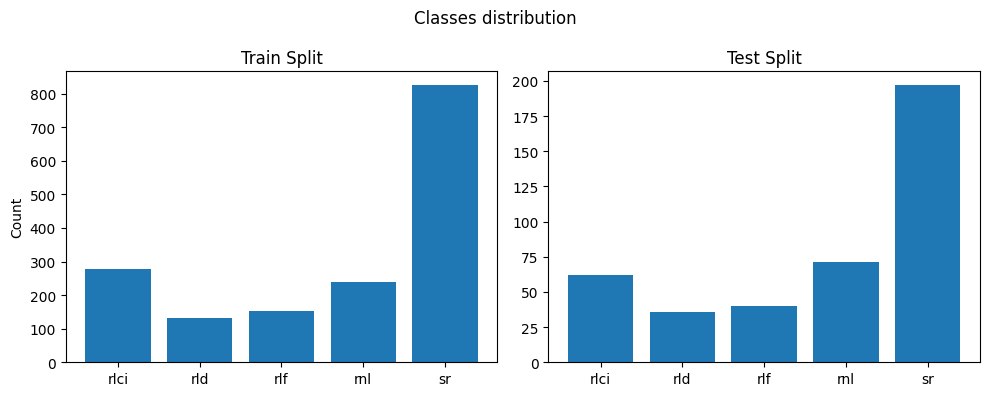

In [3]:
train_count, test_count = dataset.getSampleCountByClass()

fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.suptitle("Classes distribution")
ax[0].set_ylabel("Count")
ax[0].bar(list(zip(*train_count))[0], list(zip(*train_count))[1], tick_label=list(zip(*train_count))[2])
ax[0].set_title("Train Split")
ax[1].bar(list(zip(*test_count))[0], list(zip(*test_count))[1], tick_label=list(zip(*test_count))[2])
ax[1].set_title("Test Split")

torch.Size([16, 3, 299, 299])


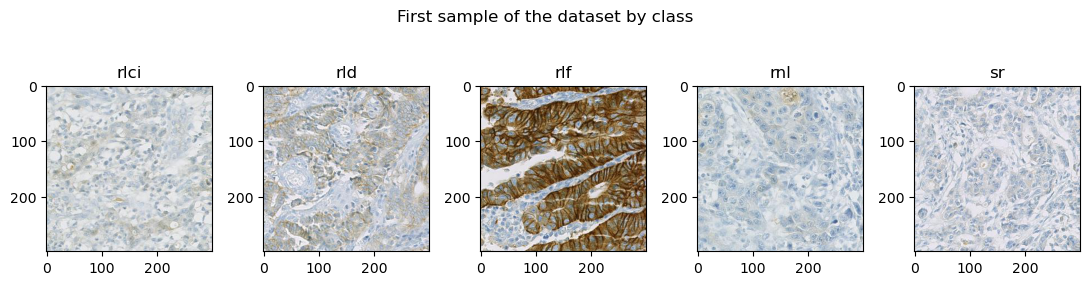

In [4]:

data_iter = iter(train_loader)
images, labels = next(data_iter)
class_first_sample = list(map(lambda x: np.where(x == np.array(labels))[0][0], dataset.class_to_idx.values()))


print(images.shape)

fig, axes = plt.subplots(tight_layout=True, ncols=len(class_first_sample), figsize=(11,3))
fig.suptitle("First sample of the dataset by class")

for ii in range(len(class_first_sample)):
    ax = axes[ii]
#     helper.imshow(images[ii], ax=ax, normalize=False)
    ax.set_title(dataset.classes[labels[class_first_sample[ii]]])
    ax.imshow(torch.transpose(images[class_first_sample[ii]], 0, 2))

/home/newt/miniconda3/envs/ds/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


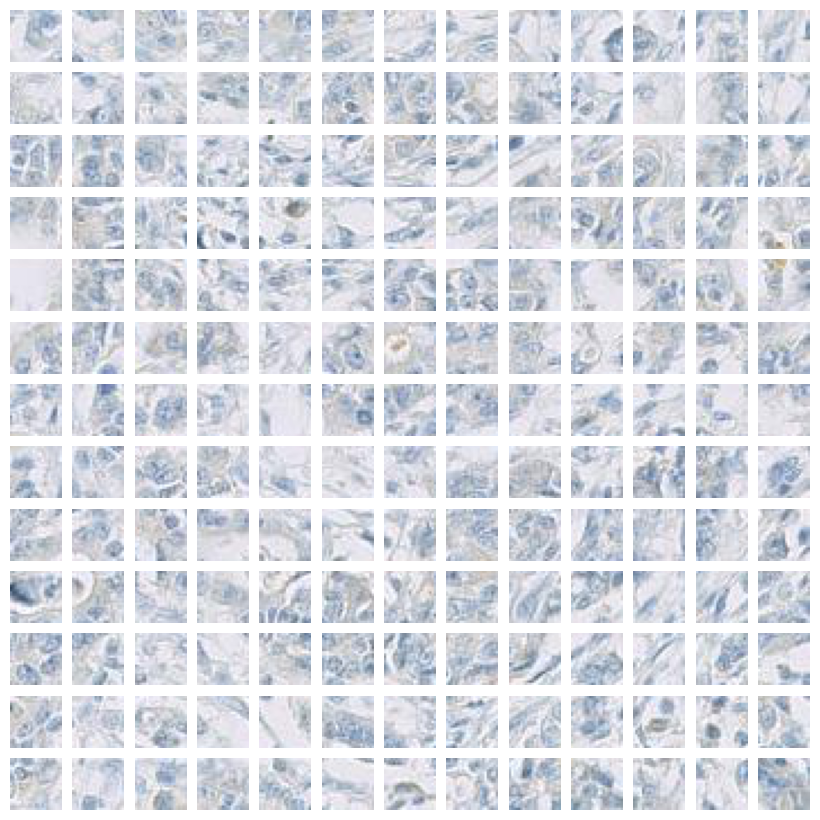

In [5]:
from patch_embedding import ImagePatcher


patcher = ImagePatcher(in_channels=IMAGE_CHANNELS, patch_size=IMAGE_WIDTH//N_PATCHES, img_size=IMAGE_HEIGHT)
gridSpec = dict(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)
data_iter = iter(train_loader)
images, labels = next(data_iter)
patches = patcher.toPatchesTensor(images[1].unsqueeze(0))
#patches = patches.reshape((1, N_PATCHES,N_PATCHES,23,23,3))
fig, axes = plt.subplots(N_PATCHES, N_PATCHES ,tight_layout=True, figsize=(8,8), sharex=True, sharey=True, gridspec_kw=gridSpec)
for i in range((N_PATCHES)):
    for j in range((N_PATCHES)):
        axes[i,j].axis('off')
        axes[i,j].set_aspect('equal')
        axes[i,j].imshow(patches[0, i, j], interpolation=None)

# axes.vlines(range(0,IMAGE_WIDTH,PATCH_WIDTH), 0, IMAGE_HEIGHT)
# axes.hlines(range(0,IMAGE_HEIGHT,PATCH_HEIGHT), 0, IMAGE_WIDTH)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

print(f"ROI divided into regions of {IMAGE_WIDTH}x{IMAGE_HEIGHT}x{IMAGE_CHANNELS}\nUsing {N_PATCHES}x{N_PATCHES} patches of {PATCH_WIDTH}x{PATCH_HEIGHT}x{IMAGE_CHANNELS}")
model = ViT(
        in_channels= IMAGE_CHANNELS, 
        img_size=IMAGE_WIDTH,
        patch_size=IMAGE_WIDTH//N_PATCHES, 
        emb_size=512,
        num_heads=16,
        depth=8,
        n_classes=len(dataset.classes), 
        dropout=0.1,
        forward_expansion=2,
        ).to(device)


# from vit_pytorch import ViT

# model = ViT(
#     image_size = IMAGE_WIDTH,
#     channels=IMAGE_CHANNELS,
#     patch_size = N_PATCHES,
#     num_classes = 5,
#     dim = 1024,
#     depth = 6,
#     heads = 16,
#     mlp_dim = 2048,
#     dropout = 0.1,
#     emb_dropout = 0.1
# ).to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.2f}MB'.format(size_all_mb))


Using device:  cuda (NVIDIA TITAN RTX)
ROI divided into regions of 299x299x3
Using 13x13 patches of 23x23x3
17726469
model size: 67.62MB


In [6]:
# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
train_losses = []
val_losses = []
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

# Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")
        val_losses.append(test_loss)


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 loss: 1.28


Training:   1%|          | 1/100 [00:11<19:20, 11.72s/it]

Test loss: 1.22
Test accuracy: 53.94%


Epoch 2/100 loss: 1.16


Training:   2%|▏         | 2/100 [00:22<18:11, 11.13s/it]

Test loss: 1.18
Test accuracy: 56.40%


Epoch 3/100 loss: 1.12


Training:   3%|▎         | 3/100 [00:33<17:39, 10.92s/it]

Test loss: 1.15
Test accuracy: 56.65%


Epoch 4/100 loss: 1.10


Training:   4%|▍         | 4/100 [00:43<17:21, 10.85s/it]

Test loss: 1.12
Test accuracy: 58.62%


Epoch 5/100 loss: 1.08


Training:   5%|▌         | 5/100 [00:54<17:05, 10.79s/it]

Test loss: 1.10
Test accuracy: 59.85%


Epoch 6/100 loss: 1.07


Training:   6%|▌         | 6/100 [01:05<16:52, 10.77s/it]

Test loss: 1.10
Test accuracy: 60.59%


Epoch 7/100 loss: 1.06


Training:   7%|▋         | 7/100 [01:15<16:40, 10.75s/it]

Test loss: 1.09
Test accuracy: 61.33%


Epoch 8/100 loss: 1.05


Training:   8%|▊         | 8/100 [01:26<16:27, 10.74s/it]

Test loss: 1.08
Test accuracy: 63.05%


Epoch 9/100 loss: 1.04


Training:   9%|▉         | 9/100 [01:37<16:23, 10.81s/it]

Test loss: 1.06
Test accuracy: 64.29%


Epoch 10/100 loss: 1.04


Training:  10%|█         | 10/100 [01:48<16:21, 10.90s/it]

Test loss: 1.06
Test accuracy: 65.27%


Epoch 11/100 loss: 1.03


Training:  11%|█         | 11/100 [01:59<16:16, 10.98s/it]

Test loss: 1.03
Test accuracy: 66.01%


Epoch 12/100 loss: 1.02


Training:  12%|█▏        | 12/100 [02:10<16:08, 11.00s/it]

Test loss: 1.04
Test accuracy: 66.50%


Epoch 13/100 loss: 1.01


Training:  13%|█▎        | 13/100 [02:22<16:00, 11.04s/it]

Test loss: 1.03
Test accuracy: 66.50%


Epoch 14/100 loss: 1.01


Training:  14%|█▍        | 14/100 [02:33<16:02, 11.19s/it]

Test loss: 1.03
Test accuracy: 67.24%


Epoch 15/100 loss: 1.00


Training:  15%|█▌        | 15/100 [02:44<15:40, 11.06s/it]

Test loss: 1.03
Test accuracy: 67.98%


Epoch 16/100 loss: 0.99


Training:  16%|█▌        | 16/100 [02:55<15:20, 10.95s/it]

Test loss: 1.02
Test accuracy: 67.73%


Epoch 17/100 loss: 0.97


Training:  17%|█▋        | 17/100 [03:05<15:03, 10.89s/it]

Test loss: 1.01
Test accuracy: 67.49%


Epoch 18/100 loss: 0.96


Training:  18%|█▊        | 18/100 [03:16<14:50, 10.86s/it]

Test loss: 1.01
Test accuracy: 65.02%


Epoch 19/100 loss: 0.95


Training:  19%|█▉        | 19/100 [03:27<14:36, 10.82s/it]

Test loss: 1.00
Test accuracy: 64.04%


Epoch 20/100 loss: 0.93


Training:  20%|██        | 20/100 [03:38<14:23, 10.80s/it]

Test loss: 0.99
Test accuracy: 61.58%


Epoch 21/100 loss: 0.92


Training:  21%|██        | 21/100 [03:48<14:11, 10.78s/it]

Test loss: 0.98
Test accuracy: 62.32%


Epoch 22/100 loss: 0.91


Training:  22%|██▏       | 22/100 [03:59<13:59, 10.77s/it]

Test loss: 0.96
Test accuracy: 61.58%


Epoch 23/100 loss: 0.91


Training:  23%|██▎       | 23/100 [04:10<13:49, 10.78s/it]

Test loss: 0.99
Test accuracy: 60.59%


Epoch 24/100 loss: 0.90


Training:  24%|██▍       | 24/100 [04:21<13:38, 10.77s/it]

Test loss: 0.95
Test accuracy: 62.07%


Epoch 25/100 loss: 0.89


Training:  25%|██▌       | 25/100 [04:31<13:28, 10.78s/it]

Test loss: 0.95
Test accuracy: 61.33%


Epoch 26/100 loss: 0.88


Training:  26%|██▌       | 26/100 [04:42<13:16, 10.77s/it]

Test loss: 0.95
Test accuracy: 58.87%


Epoch 27/100 loss: 0.88


Training:  27%|██▋       | 27/100 [04:53<13:06, 10.77s/it]

Test loss: 0.95
Test accuracy: 61.58%


Epoch 28/100 loss: 0.88


Training:  28%|██▊       | 28/100 [05:04<12:55, 10.77s/it]

Test loss: 0.93
Test accuracy: 61.58%


Epoch 29/100 loss: 0.87


Training:  29%|██▉       | 29/100 [05:14<12:43, 10.76s/it]

Test loss: 0.93
Test accuracy: 62.56%


Epoch 30/100 loss: 0.87


Training:  30%|███       | 30/100 [05:25<12:33, 10.76s/it]

Test loss: 0.94
Test accuracy: 61.82%


Epoch 31/100 loss: 0.87


Training:  31%|███       | 31/100 [05:36<12:22, 10.76s/it]

Test loss: 0.95
Test accuracy: 62.56%


Epoch 32/100 loss: 0.86


Training:  32%|███▏      | 32/100 [05:47<12:11, 10.76s/it]

Test loss: 0.93
Test accuracy: 62.56%


Epoch 33/100 loss: 0.86


Training:  33%|███▎      | 33/100 [05:58<12:02, 10.78s/it]

Test loss: 0.93
Test accuracy: 63.30%


Epoch 34/100 loss: 0.85


Training:  34%|███▍      | 34/100 [06:08<11:52, 10.80s/it]

Test loss: 0.93
Test accuracy: 63.79%


Epoch 35/100 loss: 0.85


Training:  35%|███▌      | 35/100 [06:19<11:41, 10.79s/it]

Test loss: 0.91
Test accuracy: 64.29%


Epoch 36/100 loss: 0.84


Training:  36%|███▌      | 36/100 [06:30<11:29, 10.78s/it]

Test loss: 0.93
Test accuracy: 64.04%


Epoch 37/100 loss: 0.84


Training:  37%|███▋      | 37/100 [06:41<11:17, 10.76s/it]

Test loss: 0.92
Test accuracy: 63.79%


Epoch 38/100 loss: 0.84


Training:  38%|███▊      | 38/100 [06:51<11:06, 10.75s/it]

Test loss: 0.92
Test accuracy: 64.29%


Epoch 39/100 loss: 0.84


Training:  39%|███▉      | 39/100 [07:02<10:55, 10.75s/it]

Test loss: 0.91
Test accuracy: 64.78%


Epoch 40/100 loss: 0.83


Training:  40%|████      | 40/100 [07:13<10:44, 10.75s/it]

Test loss: 0.91
Test accuracy: 65.02%


Epoch 41/100 loss: 0.83


Training:  41%|████      | 41/100 [07:24<10:34, 10.76s/it]

Test loss: 0.92
Test accuracy: 65.02%


Epoch 42/100 loss: 0.82


Training:  42%|████▏     | 42/100 [07:34<10:24, 10.77s/it]

Test loss: 0.91
Test accuracy: 65.52%


Epoch 43/100 loss: 0.83


Training:  43%|████▎     | 43/100 [07:45<10:14, 10.78s/it]

Test loss: 0.91
Test accuracy: 65.52%


Epoch 44/100 loss: 0.82


Training:  44%|████▍     | 44/100 [07:56<10:02, 10.76s/it]

Test loss: 0.90
Test accuracy: 64.04%


Epoch 45/100 loss: 0.82


Training:  45%|████▌     | 45/100 [08:07<09:58, 10.88s/it]

Test loss: 0.91
Test accuracy: 65.02%


Epoch 46/100 loss: 0.81


Training:  46%|████▌     | 46/100 [08:18<09:53, 11.00s/it]

Test loss: 0.90
Test accuracy: 64.78%


Epoch 47/100 loss: 0.81


Training:  47%|████▋     | 47/100 [08:29<09:38, 10.92s/it]

Test loss: 0.91
Test accuracy: 64.29%


Epoch 48/100 loss: 0.82


Training:  48%|████▊     | 48/100 [08:40<09:25, 10.87s/it]

Test loss: 0.92
Test accuracy: 66.26%


Epoch 49/100 loss: 0.80


Training:  49%|████▉     | 49/100 [08:51<09:15, 10.89s/it]

Test loss: 0.93
Test accuracy: 66.26%


Epoch 50/100 loss: 0.79


Training:  50%|█████     | 50/100 [09:02<09:02, 10.85s/it]

Test loss: 0.93
Test accuracy: 66.26%


Epoch 51/100 loss: 0.80


Training:  51%|█████     | 51/100 [09:12<08:50, 10.83s/it]

Test loss: 0.90
Test accuracy: 65.27%


Epoch 52/100 loss: 0.80


Training:  52%|█████▏    | 52/100 [09:23<08:39, 10.82s/it]

Test loss: 0.94
Test accuracy: 66.01%


Epoch 53/100 loss: 0.79


Training:  53%|█████▎    | 53/100 [09:34<08:27, 10.79s/it]

Test loss: 0.93
Test accuracy: 64.29%


Epoch 54/100 loss: 0.78


Training:  54%|█████▍    | 54/100 [09:45<08:16, 10.80s/it]

Test loss: 0.92
Test accuracy: 64.29%


Epoch 55/100 loss: 0.78


Training:  55%|█████▌    | 55/100 [09:55<08:05, 10.78s/it]

Test loss: 0.93
Test accuracy: 65.27%


Epoch 56/100 loss: 0.79


Training:  56%|█████▌    | 56/100 [10:06<07:54, 10.78s/it]

Test loss: 0.96
Test accuracy: 65.27%


Epoch 57/100 loss: 0.80


Training:  57%|█████▋    | 57/100 [10:17<07:44, 10.80s/it]

Test loss: 0.96
Test accuracy: 65.02%


Epoch 58/100 loss: 0.79


Training:  58%|█████▊    | 58/100 [10:28<07:33, 10.80s/it]

Test loss: 0.97
Test accuracy: 65.02%


Epoch 59/100 loss: 0.78


Training:  59%|█████▉    | 59/100 [10:39<07:22, 10.79s/it]

Test loss: 1.00
Test accuracy: 65.02%


Epoch 60/100 loss: 0.78


Training:  60%|██████    | 60/100 [10:49<07:12, 10.80s/it]

Test loss: 0.98
Test accuracy: 65.27%


Epoch 61/100 loss: 0.78


Training:  61%|██████    | 61/100 [11:00<07:01, 10.81s/it]

Test loss: 1.04
Test accuracy: 64.78%


Epoch 62/100 loss: 0.77


Training:  62%|██████▏   | 62/100 [11:11<06:50, 10.80s/it]

Test loss: 1.00
Test accuracy: 64.53%


Epoch 63/100 loss: 0.76


Training:  63%|██████▎   | 63/100 [11:22<06:39, 10.79s/it]

Test loss: 0.96
Test accuracy: 65.52%


Epoch 64/100 loss: 0.75


Training:  64%|██████▍   | 64/100 [11:33<06:28, 10.79s/it]

Test loss: 0.98
Test accuracy: 65.02%


Epoch 65/100 loss: 0.75


Training:  65%|██████▌   | 65/100 [11:43<06:17, 10.77s/it]

Test loss: 1.00
Test accuracy: 65.76%


Epoch 66/100 loss: 0.75


Training:  66%|██████▌   | 66/100 [11:54<06:06, 10.78s/it]

Test loss: 0.98
Test accuracy: 65.52%


Epoch 67/100 loss: 0.75


Training:  67%|██████▋   | 67/100 [12:05<05:55, 10.78s/it]

Test loss: 1.01
Test accuracy: 63.79%


Epoch 68/100 loss: 0.74


Training:  68%|██████▊   | 68/100 [12:16<05:45, 10.79s/it]

Test loss: 1.00
Test accuracy: 64.53%


Epoch 69/100 loss: 0.72


Training:  69%|██████▉   | 69/100 [12:27<05:34, 10.80s/it]

Test loss: 1.00
Test accuracy: 65.52%


Epoch 70/100 loss: 0.71


Training:  70%|███████   | 70/100 [12:37<05:24, 10.82s/it]

Test loss: 1.02
Test accuracy: 65.76%


Epoch 71/100 loss: 0.71


Training:  71%|███████   | 71/100 [12:48<05:13, 10.81s/it]

Test loss: 1.03
Test accuracy: 62.81%


Epoch 72/100 loss: 0.70


Training:  72%|███████▏  | 72/100 [12:59<05:02, 10.81s/it]

Test loss: 1.04
Test accuracy: 61.82%


Epoch 73/100 loss: 0.69


Training:  73%|███████▎  | 73/100 [13:10<04:52, 10.81s/it]

Test loss: 1.04
Test accuracy: 62.81%


Epoch 74/100 loss: 0.69


Training:  74%|███████▍  | 74/100 [13:21<04:41, 10.82s/it]

Test loss: 1.05
Test accuracy: 64.29%


Epoch 75/100 loss: 0.68


Training:  75%|███████▌  | 75/100 [13:31<04:30, 10.80s/it]

Test loss: 1.07
Test accuracy: 63.55%


Epoch 76/100 loss: 0.69


Training:  76%|███████▌  | 76/100 [13:42<04:18, 10.78s/it]

Test loss: 1.02
Test accuracy: 64.78%


Epoch 77/100 loss: 0.67


Training:  77%|███████▋  | 77/100 [13:53<04:07, 10.77s/it]

Test loss: 1.04
Test accuracy: 64.04%


Epoch 78/100 loss: 0.67


Training:  78%|███████▊  | 78/100 [14:04<03:56, 10.77s/it]

Test loss: 1.07
Test accuracy: 63.55%


Epoch 79/100 loss: 0.67


Training:  79%|███████▉  | 79/100 [14:14<03:46, 10.77s/it]

Test loss: 1.07
Test accuracy: 63.30%


Epoch 80/100 loss: 0.65


Training:  80%|████████  | 80/100 [14:25<03:35, 10.77s/it]

Test loss: 1.08
Test accuracy: 63.30%


Epoch 81/100 loss: 0.66


Training:  81%|████████  | 81/100 [14:36<03:24, 10.77s/it]

Test loss: 1.12
Test accuracy: 62.32%


Epoch 82/100 loss: 0.65


Training:  82%|████████▏ | 82/100 [14:47<03:14, 10.79s/it]

Test loss: 1.07
Test accuracy: 62.81%


Epoch 83/100 loss: 0.64


Training:  83%|████████▎ | 83/100 [14:58<03:03, 10.78s/it]

Test loss: 1.16
Test accuracy: 61.33%


Epoch 84/100 loss: 0.63


Training:  84%|████████▍ | 84/100 [15:08<02:52, 10.78s/it]

Test loss: 1.13
Test accuracy: 62.81%


Epoch 85/100 loss: 0.63


Training:  85%|████████▌ | 85/100 [15:19<02:41, 10.79s/it]

Test loss: 1.12
Test accuracy: 63.05%


Epoch 86/100 loss: 0.61


Training:  86%|████████▌ | 86/100 [15:30<02:30, 10.78s/it]

Test loss: 1.13
Test accuracy: 62.81%


Epoch 87/100 loss: 0.61


Training:  87%|████████▋ | 87/100 [15:41<02:20, 10.78s/it]

Test loss: 1.15
Test accuracy: 62.81%


Epoch 88/100 loss: 0.61


Training:  88%|████████▊ | 88/100 [15:51<02:09, 10.77s/it]

Test loss: 1.16
Test accuracy: 62.32%


Epoch 89/100 loss: 0.60


Training:  89%|████████▉ | 89/100 [16:02<01:58, 10.76s/it]

Test loss: 1.17
Test accuracy: 63.05%


Epoch 90/100 loss: 0.58


Training:  90%|█████████ | 90/100 [16:13<01:47, 10.76s/it]

Test loss: 1.21
Test accuracy: 62.56%


Epoch 91/100 loss: 0.58


Training:  91%|█████████ | 91/100 [16:24<01:36, 10.77s/it]

Test loss: 1.20
Test accuracy: 61.58%


Epoch 92/100 loss: 0.57


Training:  92%|█████████▏| 92/100 [16:35<01:26, 10.77s/it]

Test loss: 1.30
Test accuracy: 62.81%


Epoch 93/100 loss: 0.57


Training:  93%|█████████▎| 93/100 [16:45<01:15, 10.80s/it]

Test loss: 1.22
Test accuracy: 63.55%


Epoch 94/100 loss: 0.56


Training:  94%|█████████▍| 94/100 [16:56<01:04, 10.79s/it]

Test loss: 1.26
Test accuracy: 64.29%


Epoch 95/100 loss: 0.54


Training:  95%|█████████▌| 95/100 [17:07<00:54, 10.81s/it]

Test loss: 1.28
Test accuracy: 62.81%


Epoch 96/100 loss: 0.54


Training:  96%|█████████▌| 96/100 [17:18<00:43, 10.80s/it]

Test loss: 1.29
Test accuracy: 61.33%


Epoch 97/100 loss: 0.53


Training:  97%|█████████▋| 97/100 [17:29<00:32, 10.79s/it]

Test loss: 1.43
Test accuracy: 57.88%


Epoch 98/100 loss: 0.54


Training:  98%|█████████▊| 98/100 [17:39<00:21, 10.81s/it]

Test loss: 1.32
Test accuracy: 62.32%


Epoch 99/100 loss: 0.52


Training:  99%|█████████▉| 99/100 [17:50<00:10, 10.82s/it]

Test loss: 1.32
Test accuracy: 62.32%


Epoch 100/100 loss: 0.51


Training: 100%|██████████| 100/100 [18:01<00:00, 10.81s/it]

Test loss: 1.35
Test accuracy: 59.85%


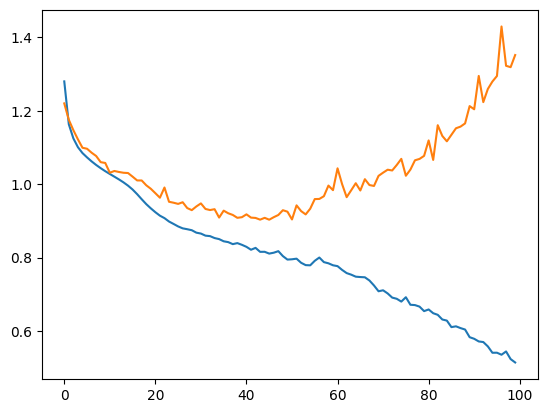

In [7]:
fig, ax = plt.subplots()

ax.plot(np.arange(100), train_losses)
ax.plot(np.arange(100), val_losses)

In [7]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
    output = model(inputs.to(device)) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth


['rlci', 'rld', 'rlf', 'rnl', 'sr']
              precision    recall  f1-score   support

           0       0.67      0.03      0.06        62
           1       0.62      0.42      0.50        36
           2       0.72      0.85      0.78        40
           3       0.50      0.46      0.48        71
           4       0.71      0.96      0.82       197

    accuracy                           0.67       406
   macro avg       0.65      0.54      0.53       406
weighted avg       0.66      0.67      0.61       406



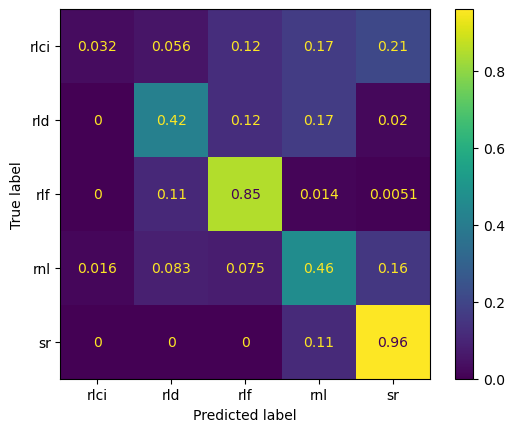

In [8]:
from sklearn.metrics import classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
print(dataset.classes)
print(classification_report(y_pred=y_pred, y_true=y_true))
disp = ConfusionMatrixDisplay(confusion_matrix(y_pred=y_pred, y_true=y_true)/confusion_matrix(y_pred=y_pred, y_true=y_true).sum(axis=1), display_labels=dataset.classes)

disp.plot()

In [13]:
y_pred[y_pred==0]

4

In [14]:
print(y_pred)

[4, 4, 4, 2, 4, 1, 4, 2, 2, 1, 2, 4, 4, 4, 2, 4, 4, 4, 1, 4, 4, 4, 1, 4, 3, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 2, 4, 4, 1, 2, 3, 4, 1, 2, 1, 4, 4, 1, 1, 4, 2, 3, 4, 4, 4, 4, 3, 4, 2, 4, 1, 4, 4, 4, 4, 4, 4, 2, 3, 2, 4, 4, 1, 2, 4, 4, 4, 4, 4, 4, 2, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1, 3, 3, 4, 4, 3, 4, 4, 1, 2, 4, 2, 1, 2, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 1, 2, 1, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 4, 1, 4, 1, 4, 1, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 3, 4, 4, 4, 4, 1, 4, 2, 1, 4, 4, 1, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 1, 4, 4, 4, 4, 4, 2, 3, 4, 4, 4, 4, 3, 4, 4, 3, 2, 4, 4, 4, 4, 2, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 1, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 1, 4, 3, 4, 4, 4, 1, 2, 4, 1, 4, 3, 1, 2, 4, 2, 3, 4, 4, 2, 4, 4, 1, 4, 2, 1, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 3, 4, 1, 4, 4, 4, 4, 1, 2, 4, 4, 4, 1, 2, 4, 4, 3, 1, 4, 4, 4, 3, 4, 4, 4, 2, 